In [1]:
import sys
sys.path.append('../')

from typing import Tuple, Union, List
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm as tqdm

import torch
import torch.nn as nn

import torch_geometric as pyg
from torch_geometric.utils.convert import from_networkx

from src.utils import *
from dataset import *
from src.train import train, test
from src.model import KnnEstimator
from src.dataloaders import make_data_loaders_from_dataset

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
G = nx.readwrite.read_gpickle('data/network128.gpickle')

In [3]:
# Pytorch geometric Data object. For now used only for storing node embedding. 
# Supposed to be used in the future for obtaining node embeddings.
pyg_graph = from_networkx(G)
pyg_graph.to(device)

/home/eldervald/miniconda3/envs/traffic/lib/python3.9/site-packages/torch_geometric/utils/convert.py:170: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/torch/csrc/utils/tensor_new.cpp:201.)
  data[key] = torch.tensor(value)


Data(x=[60789, 128], edge_index=[2, 151294], lng=[60789], lat=[60789], id=[60789], dist=[151294])

$$T(a) = \sum_{b \neq a,\space b\subset Train } T(b)w(a, b), \textrm{where summation is calculated for the {\bf k} nearest neighbors.}$$

$$ w(a,b)= \frac{e^{u(a,b)}}{\sum_{b \neq a} e^{u(a, b)}} ;$$

$u(a, b) = f(x_a, x_b, dist_{a,b}) = MLP(concat[hadamard(x_a, x_b), dist_{a, b}]);$

$hadamard(x_a, x_b)$ - per coordinate product;

$x_a$ is an embedding for a node **a**;

So for this model $MLP$ parameters are optimized.

In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.hidden_dim = hidden_dim

        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.hidden_dim),
            nn.ReLU(),

            nn.Dropout(0.2),
    
            nn.Linear(self.hidden_dim, 1))

    def forward(self, X):
        out = self.layers(X)
        return out



class Estimator(KnnEstimator):
    def __init__(self, pyg_graph: pyg.data.Data, observations: Tuple[List, List]) -> None:
        super().__init__(pyg_graph, observations, neighbors_num=30)

        self.mlp = MLP(129, 128)

        self.k = nn.Parameter(torch.rand(1))
        # self.k = torch.tensor([1.0]).to(device)
        self.lambda_1 = nn.Parameter(torch.rand(1))
        self.lambda_2 = nn.Parameter(torch.rand(1))

    def forward(self, X):
        # getting nearest observed nodes
        X_indices = torch.as_tensor(self.node_to_gidx(X.detach().cpu()))
        dists, indices = self.get_kneighbors(X_indices)
        dists = dists.to(device)
        indices = indices.to(device)

        # finding corresponding node embedding of neighbors
        neighbors_indices = torch.as_tensor(self.node_to_gidx(self.obs_nodes[indices]), device=device)
        neighbors_embeds = self.g.x[neighbors_indices]
        
        # computing similarities between node ans its neighbors
        X_embeds = self.g.x[X_indices]

        input = torch.cat([torch.mul(X_embeds[:, None].expand(-1, neighbors_embeds.shape[1], -1),
                                     neighbors_embeds),
                           dists[:, :, None]
                           ], dim=2)

        
        out = self.mlp(input.reshape(-1, input.shape[-1]).float()).reshape(-1, neighbors_embeds.shape[1])

        # normalizization
        # att_weights = nn.functional.normalize(out, p=1)
        att_weights = nn.functional.softmax(out, dim=-1)

        targets = self.obs_targets[indices].to(device)

        # interpolation 
        result = torch.sum(att_weights.mul(targets), dim=-1)

        return result

In [8]:
results = dict()

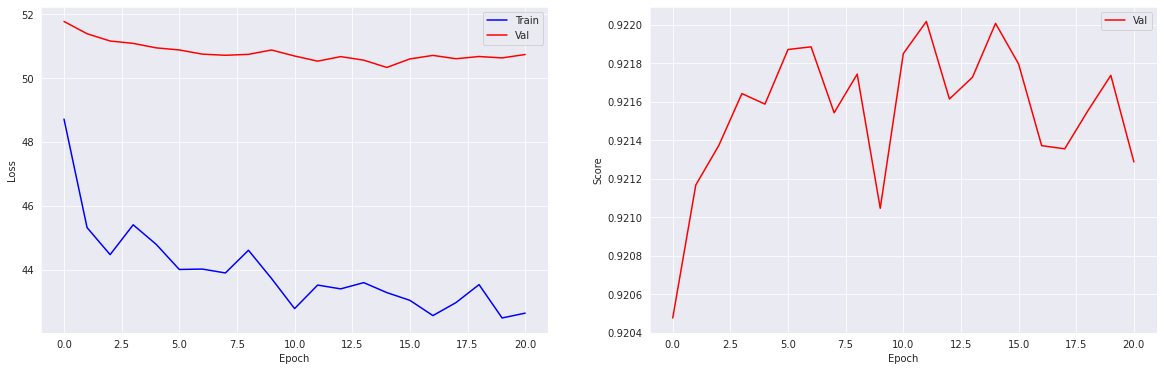

Day 1, Test loss: 42.7011, test score: 0.9125


In [9]:
loss_fn = nn.HuberLoss(delta=20).to(device)
model = None

for path in tqdm(glob.glob('datasets/*')[:1]):
    print(path)

    try:
        ds = torch.load(path)
    except:
        continue
    
    print(len(ds))

    train_loader, val_loader, test_loader = make_data_loaders_from_dataset(ds, batch_size=128)
    train_batches = [batch for batch in train_loader]
    train_nodes = [n for batch in train_batches for n in batch[0]]
    train_targets = torch.cat([batch[1] for batch in train_batches])


    if model is None:
        model = Estimator(pyg_graph, train_nodes, train_targets).to(device)
    else:
        model.set_observations(train_nodes, train_targets)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9)

    best_model = train(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=10, plotting=True)
    test_loss, test_score = test(best_model, test_loader, loss_fn, device)

    # for name, param in best_model.named_parameters():
        # print(name, param)

    results[f'day_{day}'] = test_score 
    print(f'Day {day}, Test loss: {test_loss:.4f}, test score: {test_score:.4f}')

In [23]:
import json

with open('results/gnn1.json', mode='w') as f:
    json.dump(results, f, indent=4)